## Run 1

In [3]:
## LOADING DATA

import pickle

# Load ribociclib data from data/preprocessed 

with open('data/preprocessed/palbociclib_data.pkl', 'rb') as f:
    palbociclib_data = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'data/preprocessed/palbociclib_data.pkl'

In [2]:
import dynmarker.FeatureSelection as fs 

feature_data, label_data = fs.create_feature_and_label(palbociclib_data)

In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.feature_selection import f_regression, SelectKBest
# from sklearn import set_config
# set_config(transform_output = "pandas")

import pandas as pd 

from functools import partial

scaler = Normalizer()
feature_selector = SelectKBest(score_func=f_regression, k=20)
model = ElasticNet()

scores, pval = f_regression(feature_data, label_data)
scores # score for each feature at their respective index

K = 20
mrmr_score_func = partial(fs.mrmr_select_fcq_sklearn, K=K)
mrmr_selector = SelectKBest(mrmr_score_func, k=K)


In [4]:
pipe = Pipeline([('feature_selector', feature_selector), ('regressor', model)])

scores = cross_val_score(pipe, feature_data, label_data, cv=5, scoring='neg_mean_squared_error')

print(f'NORM mean: {-scores.mean():.4f}, std: {scores.std():.4f}')

NORM mean: 1.7761, std: 0.0980


## Run 2 

In [1]:
## LOADING DATA

import pickle
import dynmarker.FeatureSelection as fs 

# Load palbociclib data from data/preprocessed 

with open('data/preprocessed/palbociclib_data.pkl', 'rb') as f:
    palbociclib_data = pickle.load(f)


In [2]:

feature_data, label_data = fs.create_feature_and_label(palbociclib_data)
y_std = label_data.std()
y_std


1.5952913449402224

In [8]:

import pandas as pd
import numpy as np 

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, ElasticNet
from sklearn.svm import LinearSVR, LinearSVC, SVC, SVR
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score

from dynmarker.EvaluationPipeline import EvaluationPipeline
from dynmarker.FeatureSelection import example_run_model_func


In [9]:
random_eval = EvaluationPipeline()
random_eval.set_function(example_run_model_func)

In [10]:
random_eval.run_function(feature_data, label_data, 10, k_ranges=range(1,201,10), model_list=[LinearRegression(), Lasso(), ElasticNet()], n_cores=6)

--- Finished LinearRegression using 6 cores ---
--- Finished Lasso using 6 cores ---
--- Finished ElasticNet using 6 cores ---


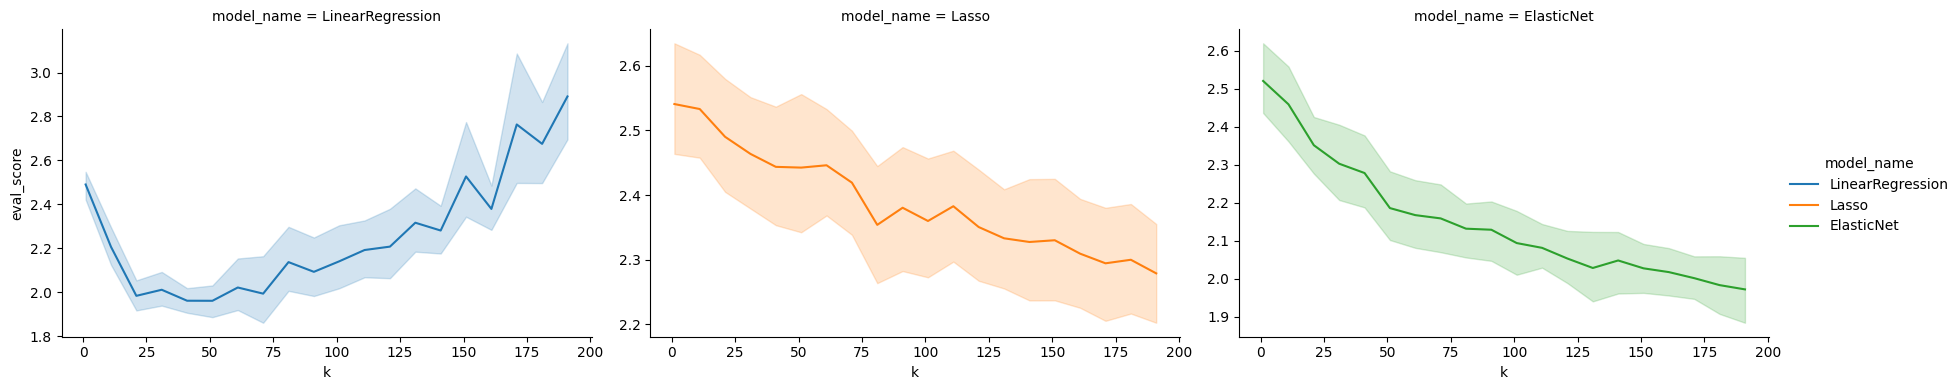

In [11]:
# plot a line plot the average score and std for each k value over the i iterations, show error bar as std

import matplotlib.pyplot as plt
import seaborn as sns

evaluation_df_lite = random_eval.evaluation_df

# get rid of the outliers, 20 times the value of the label data's standard deviation is the cut-off
processed_evaluation_df = evaluation_df_lite[evaluation_df_lite['eval_score'] < y_std*5]
# processed_evaluation_df = evaluation_df_lite

# plot each model on the different figure, multi-figure plot

g = sns.FacetGrid(processed_evaluation_df, col='model_name', col_wrap=3, hue='model_name', height=4, aspect=1.5, sharey=False)
g.map(sns.lineplot, 'k', 'eval_score')
g.add_legend()
# plt.grid()
plt.show()

In [12]:
# train test split using MLPRegressor

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(feature_data, label_data, test_size=0.2, random_state=42)

from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(hidden_layer_sizes=(100, 100, 100), max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

from sklearn.metrics import mean_squared_error

score = mean_squared_error(y_test, y_pred)

print(score)

2.3337973445311193


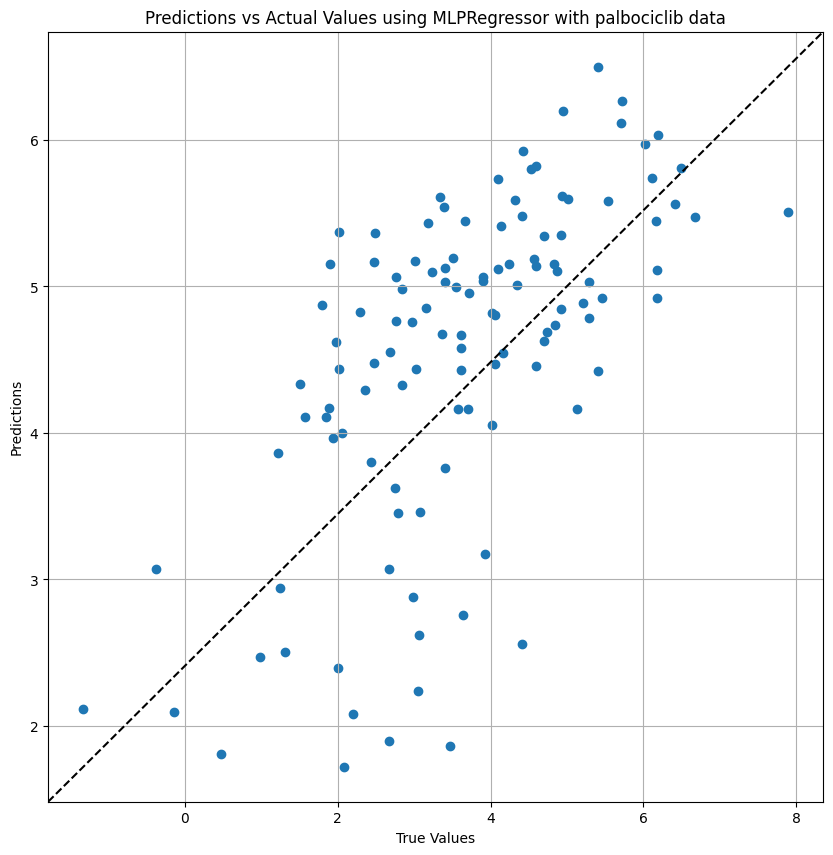

Correlation coefficient: 0.6294, p-value: 0.0000


In [24]:
# plot the predictions vs the actual values

import matplotlib.pyplot as plt

# add in a line of y=x

plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, ls='--', c='k')

# title
plt.title('Predictions vs Actual Values using MLPRegressor with palbociclib data')
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid()
plt.show()

# pearson correlation coefficient

from scipy.stats import pearsonr

corr, p_val = pearsonr(y_test, y_pred)

# print the correlation coefficient and p-value
print(f'Correlation coefficient: {corr:.4f}, p-value: {p_val:.4f}')



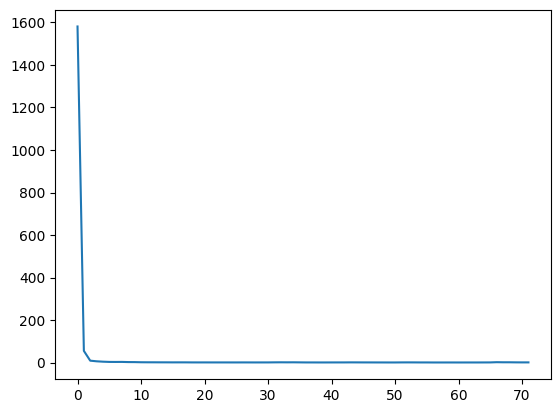

In [22]:
# show loss curve

plt.plot(mlp.loss_curve_)


## Feature Selection in mRNA expression data

In [1]:
import pandas as pd
import pickle

# import GDSC2 drug response data using pickle

with open('data/drug-response/GDSC2/cache_gdsc2.pkl', 'rb') as f:
    gdsc2 = pickle.load(f)
    gdsc2_info = pickle.load(f)

# import CCLE gene expression data using pickle

with open('data/gene-expression/CCLE_Public_22Q2/ccle_expression.pkl', 'rb') as f:
    gene_entrez = pickle.load(f)
    ccle = pickle.load(f)

# import CCLE sample info data using pickle

with open('data/gene-expression/CCLE_Public_22Q2/ccle_sample_info.pkl', 'rb') as f:
    ccle_sample_info = pickle.load(f)

# import STRING database using pickle

with open('data/protein-interaction/STRING/string_df.pkl', 'rb') as f:
    string_df = pickle.load(f)
    string_df_info = pickle.load(f)
    string_df_alias = pickle.load(f)

# with open('data/protein-interaction/STRING/ccle_to_string_id_df.pkl', 'rb') as f:
#     ccle_to_string_id_df = pickle.load(f)


In [2]:
import DataFunctions as utils

# get the drug response data for palbociclib
palbociclib_data = utils.create_joint_dataset_from_ccle_gdsc2('Palbociclib', gdsc2, ccle, ccle_sample_info)

feature_data, label_data = utils.create_feature_and_label(palbociclib_data)

In [3]:
feature_data.head()

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,H3C2,H3C3,AC098582.1,DUS4L-BCAP29,C8orf44-SGK3,ELOA3B,NPBWR1,ELOA3D,ELOA3,CDR1
SANGER_MODEL_ID,,,,,,,,,,,,,,,,,,,,,
SIDM00872,5.296090,0.000000,6.794416,3.452859,5.260778,0.042644,4.339137,5.833143,7.313246,4.764474,...,1.827819,0.000000,0.847997,1.704872,0.411426,0.000000,1.063503,0.0,0.000000,0.0
SIDM00866,5.214125,0.000000,6.328047,3.168321,4.654206,0.042644,0.432959,6.574102,5.140779,5.114783,...,0.000000,0.000000,0.298658,1.584963,0.695994,0.000000,2.693766,0.0,0.000000,0.0
SIDM00885,5.241840,0.201634,5.615299,3.090853,3.732269,0.084064,0.111031,4.026800,5.471513,6.019480,...,0.632268,0.000000,0.422233,1.250962,0.505891,0.111031,0.070389,0.0,0.111031,0.0
SIDM00884,3.481557,0.000000,7.070389,2.341986,3.679199,0.176323,3.420887,5.854494,5.976134,5.112283,...,2.327687,0.226509,0.650765,2.477677,0.000000,0.000000,0.042644,0.0,0.084064,0.0
SIDM00874,4.903038,0.000000,7.177719,2.744161,4.648465,0.150560,0.070389,5.819924,4.374344,3.814550,...,2.440952,1.695994,0.367371,1.505891,0.214125,0.137504,0.704872,0.0,0.000000,0.0


In [4]:
label_data.head()

SANGER_MODEL_ID
SIDM00872    4.887773
SIDM00866    5.065262
SIDM00885    4.133027
SIDM00884    3.310621
SIDM00874    5.586256
Name: LN_IC50, dtype: float64

In [5]:
# using f-regression to select the top 20 features 

from sklearn.feature_selection import SelectKBest, f_regression

selector = SelectKBest(f_regression, k=20)
selector.fit(feature_data, label_data)

# get the selected features

selected_features = feature_data.columns[selector.get_support()]

selected_features


Index(['WAS', 'BCAR1', 'NCKAP1', 'ARHGAP15', 'RPL3', 'TJP1', 'RASAL3',
       'AMOTL2', 'NCKAP1L', 'SDC4', 'LAMA5', 'SLC49A4', 'PTPRF', 'CD53',
       'TUFT1', 'PTPN7', 'PPIC', 'PXDC1', 'P2RY8', 'IKZF1'],
      dtype='object')

score using selected features: 2.0132, score using all features: 1.9958


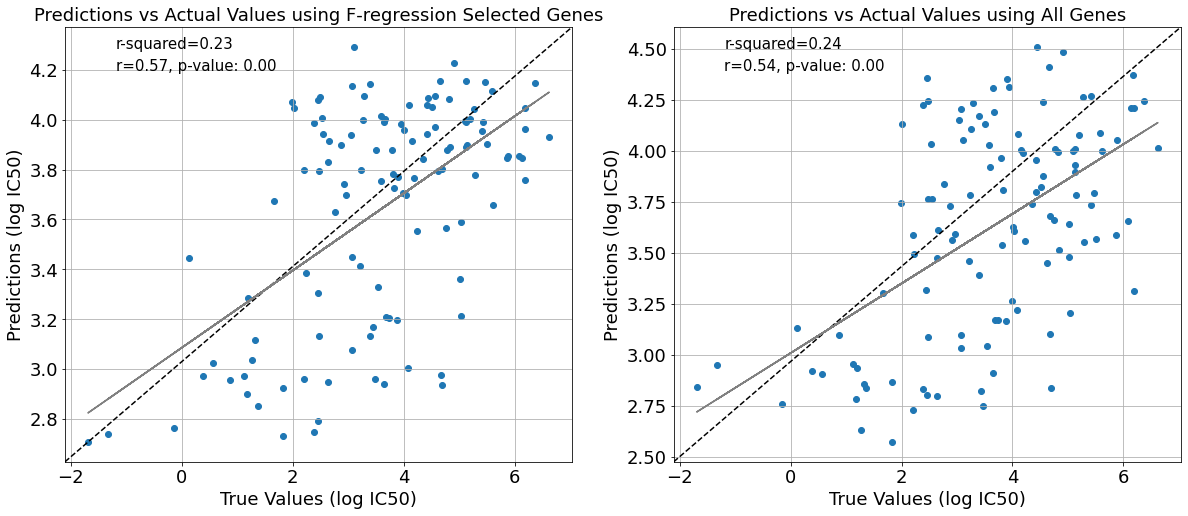

In [6]:
# split the data into train and test set

from sklearn.model_selection import train_test_split

# import lasso regression model

from sklearn.linear_model import Lasso

import numpy as np

X_train, X_test, y_train, y_test = train_test_split(feature_data, label_data, test_size=0.2, 
                                                    random_state=np.random.randint(1000))

# perform feature selection on the training set

selector = SelectKBest(f_regression, k=20)
selector.fit(X_train, y_train)

# get the selected features

selected_features = X_train.columns[selector.get_support()]

# train the model on the selected features

repeat = Lasso()
repeat.fit(X_train[selected_features], y_train)

lasso_all_features = Lasso()
lasso_all_features.fit(X_train, y_train)

# get the predictions

y_pred = repeat.predict(X_test[selected_features])
predictions_all_features = lasso_all_features.predict(X_test)

# get the score

from sklearn.metrics import mean_squared_error

score = mean_squared_error(y_test, y_pred)
score_all = mean_squared_error(y_test, predictions_all_features)

print(f'score using selected features: {score:.4f}, score using all features: {score_all:.4f}')

# plot the predictions vs the actual values

import matplotlib.pyplot as plt
import Visualisation as vis

# make a 1x2 subplots
fig, ax = plt.subplots(1, 2, figsize=(20,8))

# for each axis, plot the predictions vs the actual values
vis.plot_predictions_vs_actual_values(y_test, y_pred, ax=ax[0], 
                                      title='Predictions vs Actual Values using F-regression Selected Genes',
                                      x_label='True Values (log IC50)', y_label='Predictions (log IC50)',
                                      minitext_size=15)
vis.plot_predictions_vs_actual_values(y_test, predictions_all_features, ax=ax[1], 
                                      title='Predictions vs Actual Values using All Genes',
                                      x_label='True Values (log IC50)', y_label='Predictions (log IC50)',
                                      minitext_size=15)

# show the plot
plt.show()

In [43]:
# iterate feature selection for {repeat} times 
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

# import elastic net regression model and random forest regression model

from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor

repeats = 100
test_size = 0.1
exp_ids = ['ANOVA 10 Genes', 'ANOVA 100 Genes', 'ANOVA 1000 Genes', 'All Genes']
feature_selection_size = [10, 100, 1000, feature_data.shape[1]]

data = []
data_column_names = ['exp_id', 'random_seed', 'score', 'y_pred', 'y_test', 'selected_features', 'pearson_corr', 'pearson_p_val', 'r_squared']

for i in range(repeats):
    random_seed = np.random.randint(1000)
    X_train, X_test, y_train, y_test = train_test_split(feature_data, label_data, test_size=test_size, 
                                                        random_state=random_seed)

    for exp_id, k in zip(exp_ids, feature_selection_size):
        selector = SelectKBest(f_regression, k=k)
        selector.fit(X_train, y_train)
        selected_features = X_train.columns[selector.get_support()].tolist()
        model = ElasticNet()
        model.fit(X_train[selected_features], y_train)
        y_pred = model.predict(X_test[selected_features])
        score = mean_squared_error(y_test, y_pred)
        corr, p_val = pearsonr(y_test, y_pred)
        r_squared = r2_score(y_test, y_pred)

        # print debug info
        print(f'iteration: {i}, score: {score:.4f}, pearson corr: {corr:.4f}, pearson p_val: {p_val:.4f}, r_squared: {r_squared:.4f}')

        row = [exp_id, random_seed, score, y_pred, y_test.tolist(), selected_features, corr, p_val, r_squared]
        data.append(row)

# save result in a dataframe
collection_df_freg = pd.DataFrame(data, columns=data_column_names)



iteration: 0, score: 2.3322, pearson corr: 0.3365, pearson p_val: 0.0034, r_squared: 0.1080
iteration: 0, score: 2.1439, pearson corr: 0.4311, pearson p_val: 0.0001, r_squared: 0.1800
iteration: 0, score: 1.9484, pearson corr: 0.5113, pearson p_val: 0.0000, r_squared: 0.2547
iteration: 0, score: 1.9201, pearson corr: 0.5235, pearson p_val: 0.0000, r_squared: 0.2656
iteration: 1, score: 1.6688, pearson corr: 0.3956, pearson p_val: 0.0005, r_squared: 0.1368
iteration: 1, score: 1.5650, pearson corr: 0.4479, pearson p_val: 0.0001, r_squared: 0.1906
iteration: 1, score: 1.5204, pearson corr: 0.4709, pearson p_val: 0.0000, r_squared: 0.2136
iteration: 1, score: 1.4726, pearson corr: 0.4956, pearson p_val: 0.0000, r_squared: 0.2383
iteration: 2, score: 1.2318, pearson corr: 0.3512, pearson p_val: 0.0022, r_squared: 0.1097
iteration: 2, score: 1.2071, pearson corr: 0.3796, pearson p_val: 0.0009, r_squared: 0.1276
iteration: 2, score: 1.1833, pearson corr: 0.4027, pearson p_val: 0.0004, r_squa

In [8]:
collection_df_freg.head()

,exp_id,random_seed,score,y_pred,y_test,selected_features,pearson_corr,pearson_p_val,r_squared
0,f_regression_10,620,1.957267,"[4.255572188494628, 3.3900301246596136, 4.0202...","[5.336338, 3.846006, 4.344644, 3.877719, 5.610...","[WAS, RPL3, AMOTL2, NCKAP1L, SDC4, SLC49A4, TU...",0.653793,1.972687e-08,0.338601
1,f_regression_100,620,1.838293,"[4.256705055847528, 3.5309831155734934, 4.1113...","[5.336338, 3.846006, 4.344644, 3.877719, 5.610...","[TSPAN6, ITGAL, ITGA3, TNFRSF12A, TRAF3IP3, WA...",0.681921,2.741444e-09,0.378805
2,f_regression_1000,620,1.905674,"[4.283820635330075, 3.38266785898828, 4.163590...","[5.336338, 3.846006, 4.344644, 3.877719, 5.610...","[TSPAN6, FGR, FUCA2, BAD, LASP1, CD38, ITGAL, ...",0.659929,1.305588e-08,0.356036
3,f_regression_10,162,1.305204,"[3.818082969284555, 3.462112526421485, 4.42924...","[3.909883, 4.924714, 6.142088, 2.679671, 4.007...","[WAS, RPL3, AMOTL2, SDC4, LAMA5, SLC49A4, TUFT...",0.628321,9.945606e-08,0.381051
4,f_regression_100,162,1.359539,"[4.051682481011226, 3.5480550787197584, 4.0157...","[3.909883, 4.924714, 6.142088, 2.679671, 4.007...","[TSPAN6, ITGA3, TNFRSF12A, BAIAP2L1, TRAF3IP3,...",0.601634,4.663412e-07,0.355285


In [9]:
# std and mean of pearson correlation
print(f'pearson correlation mean: {collection_df_freg["pearson_corr"].mean():.4f}, std: {collection_df_freg["pearson_corr"].std():.4f}')

pearson correlation mean: 0.5878, std: 0.0919


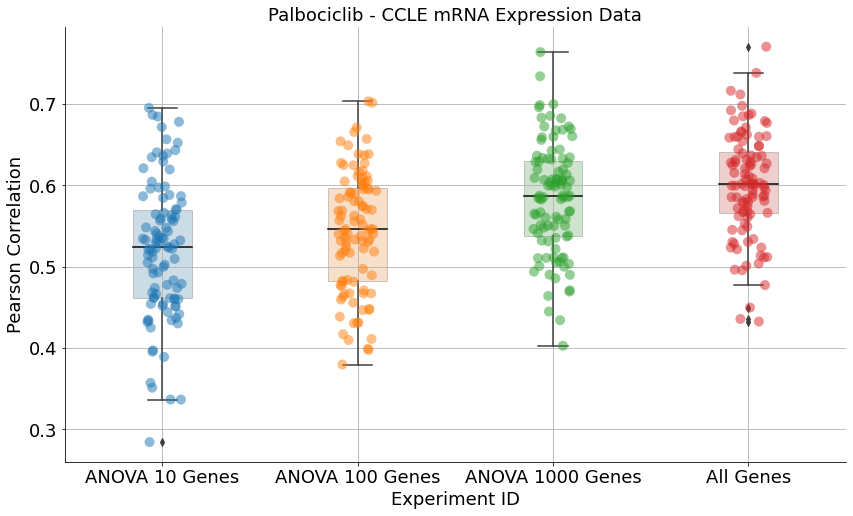

In [44]:
# plot collection df as a boxplot

import seaborn as sns
import matplotlib.pyplot as plt

import Visualisation as vis

fig, ax = plt.subplots(figsize=(14,8))
    
vis.plot_box_plot(collection_df_freg, 'exp_id', 'pearson_corr', 'Palbociclib - CCLE mRNA Expression Data',
                'Experiment ID', 'Pearson Correlation', ax=ax)


plt.grid()
sns.despine()
# show the plot
plt.show()


This concludes that f-regression simply cannot outperform training using all features. 

In [ ]:
# using STRING database to select the 1st,2nd and 3rd degree neighbours of the drug target

## Feature Selection using proteomic expression data from Goncalves et al.

In [18]:
import pandas as pd
import pickle

# import GDSC2 drug response data using pickle

with open('data/drug-response/GDSC2/cache_gdsc2.pkl', 'rb') as f:
    gdsc2 = pickle.load(f)
    gdsc2_info = pickle.load(f)

# import proteomic expression 
with open('data/proteomic-expression/goncalves-2022-cell/goncalve_proteome_fillna_processed.pkl', 'rb') as f:
    joined_full_protein_matrix = pickle.load(f)
    joined_sin_peptile_exclusion_matrix = pickle.load(f)

# import STRING database using pickle

with open('data/protein-interaction/STRING/string_df.pkl', 'rb') as f:
    string_df = pickle.load(f)
    string_df_info = pickle.load(f)
    string_df_alias = pickle.load(f)

# open STRING to goncalves mapping file

with open('data\protein-interaction\STRING\goncalve_to_string_id_df.pkl', 'rb') as f:
    goncalve_to_string_id_df = pickle.load(f)




In [19]:
import DataFunctions as utils 

# create the full dataset

palbociclib_proteomic_df = utils.create_joint_dataset_from_proteome_gdsc('Palbociclib', 
                                                                         joined_sin_peptile_exclusion_matrix, gdsc2)

In [20]:
feature_data, label_data = utils.create_feature_and_label(palbociclib_proteomic_df)

In [21]:
feature_data.head()

,P37108;SRP14_HUMAN,Q96JP5;ZFP91_HUMAN,Q9Y4H2;IRS2_HUMAN,P36578;RL4_HUMAN,Q6SPF0;SAMD1_HUMAN,O76031;CLPX_HUMAN,Q8WUQ7;CATIN_HUMAN,A6NIH7;U119B_HUMAN,Q9BTD8;RBM42_HUMAN,Q9P258;RCC2_HUMAN,...,P33151;CADH5_HUMAN,Q5EBL4;RIPL1_HUMAN,P49715;CEBPA_HUMAN,Q5TA45;INT11_HUMAN,O14924;RGS12_HUMAN,Q7Z3B1;NEGR1_HUMAN,O60669;MOT2_HUMAN,Q13571;LAPM5_HUMAN,Q96JM2;ZN462_HUMAN,P35558;PCKGC_HUMAN
SIDM00042,5.70786,0.00000,0.0000,6.22574,0.00000,4.49579,0.0,0.00000,2.87981,0.00000,...,0.0,0.0000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
SIDM00044,6.04591,3.69356,0.0000,7.07092,3.49594,4.05438,0.0,0.00000,3.44202,4.34237,...,0.0,3.0226,0.0,0.0,0.0,0.0,2.16952,0.0,0.0,0.0
SIDM00045,6.20582,2.88118,0.0000,8.25336,3.35439,5.09923,0.0,0.00000,3.56256,6.01081,...,0.0,0.0000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
SIDM00047,6.80469,2.78737,0.0000,7.58653,2.14980,5.43356,0.0,3.50808,3.43601,5.12233,...,0.0,0.0000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
SIDM00049,6.28591,0.00000,2.1142,6.98525,3.52912,4.74122,0.0,0.00000,3.51710,5.81359,...,0.0,0.0000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0


In [22]:
label_data.head()

SIDM00042    5.344381
SIDM00044    2.482390
SIDM00045    0.057768
SIDM00047    2.949412
SIDM00049    3.275468
Name: LN_IC50, dtype: float64

score using selected features: 2.2609, score using all features: 2.1931


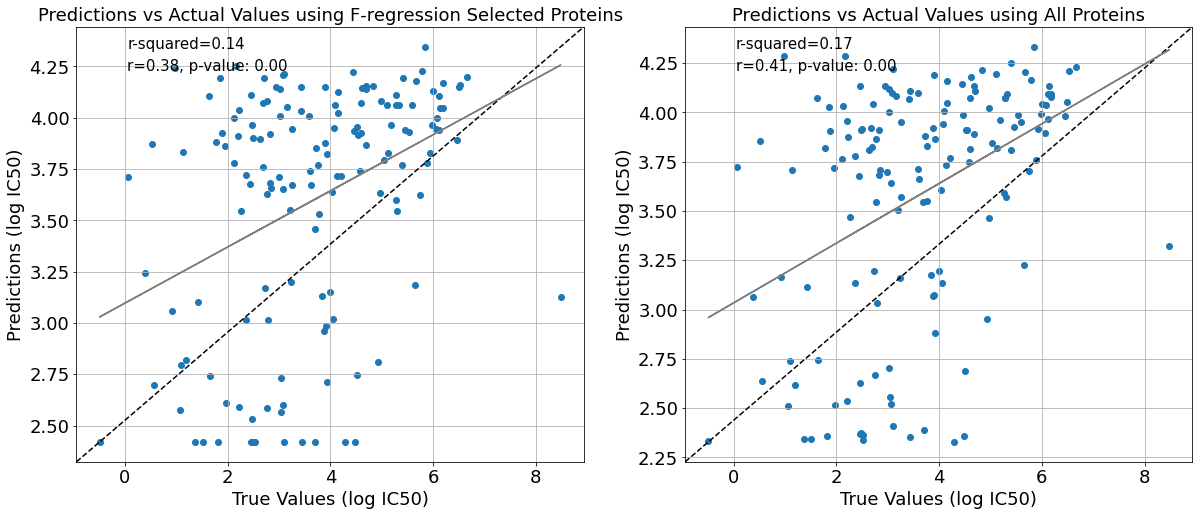

In [23]:
# split the data into train and test set

from sklearn.model_selection import train_test_split

# import lasso regression model

from sklearn.linear_model import Lasso

import numpy as np

X_train, X_test, y_train, y_test = train_test_split(feature_data, label_data, test_size=0.2, 
                                                    random_state=np.random.randint(1000))

# perform feature selection on the training set

selector = SelectKBest(f_regression, k=100)
selector.fit(X_train, y_train)

# get the selected features

selected_features = X_train.columns[selector.get_support()]

# train the model on the selected features

lasso = Lasso()
lasso.fit(X_train[selected_features], y_train)

lasso_all_features = Lasso()
lasso_all_features.fit(X_train, y_train)

# get the predictions

y_pred = lasso.predict(X_test[selected_features])
predictions_all_features = lasso_all_features.predict(X_test)

# get the score

from sklearn.metrics import mean_squared_error

score = mean_squared_error(y_test, y_pred)
score_all = mean_squared_error(y_test, predictions_all_features)

print(f'score using selected features: {score:.4f}, score using all features: {score_all:.4f}')

# plot the predictions vs the actual values

import matplotlib.pyplot as plt
import Visualisation as vis

# make a 1x2 subplots
fig, ax = plt.subplots(1, 2, figsize=(20,8))

# for each axis, plot the predictions vs the actual values
vis.plot_predictions_vs_actual_values(y_test, y_pred, ax=ax[0], 
                                      title='Predictions vs Actual Values using F-regression Selected Proteins',
                                      x_label='True Values (log IC50)', y_label='Predictions (log IC50)',
                                      minitext_size=15)
vis.plot_predictions_vs_actual_values(y_test, predictions_all_features, ax=ax[1], 
                                      title='Predictions vs Actual Values using All Proteins',
                                      x_label='True Values (log IC50)', y_label='Predictions (log IC50)',
                                      minitext_size=15)

# show the plot
plt.show()

In [29]:
# iterate feature selection for {repeat} times 
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

# import elastic net regression model and random forest regression model

from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor

repeats = 100
test_size = 0.1
exp_ids = ['ANOVA Protome 10', 'ANOVA Protome 100', 'ANOVA Protome 1000']
feature_selection_size = [10, 100, 1000]

data = []
data_column_names = ['exp_id', 'random_seed', 'score', 'y_pred', 'y_test', 'selected_features', 'pearson_corr', 'pearson_p_val', 'r_squared']

for i in range(repeats):
    random_seed = np.random.randint(1000)
    X_train, X_test, y_train, y_test = train_test_split(feature_data, label_data, test_size=test_size, 
                                                        random_state=random_seed)

    for exp_id, k in zip(exp_ids, feature_selection_size):
        selector = SelectKBest(f_regression, k=k)
        selector.fit(X_train, y_train)
        selected_features = X_train.columns[selector.get_support()].tolist()
        model = ElasticNet()
        model.fit(X_train[selected_features], y_train)
        y_pred = model.predict(X_test[selected_features])
        score = mean_squared_error(y_test, y_pred)
        corr, p_val = pearsonr(y_test, y_pred)
        r_squared = r2_score(y_test, y_pred)

        # print debug info
        print(f'iteration: {i}, score: {score:.4f}, pearson corr: {corr:.4f}, pearson p_val: {p_val:.4f}, r_squared: {r_squared:.4f}')

        row = [exp_id, random_seed, score, y_pred, y_test.tolist(), selected_features, corr, p_val, r_squared]
        data.append(row)

# save result in a dataframe
collection_df_freg_proteome = pd.DataFrame(data, columns=data_column_names)



iteration: 0, score: 1.7349, pearson corr: 0.3889, pearson p_val: 0.0006, r_squared: 0.1494
iteration: 0, score: 1.7278, pearson corr: 0.3976, pearson p_val: 0.0005, r_squared: 0.1529
iteration: 0, score: 1.6640, pearson corr: 0.4341, pearson p_val: 0.0001, r_squared: 0.1842
iteration: 1, score: 1.5310, pearson corr: 0.5154, pearson p_val: 0.0000, r_squared: 0.2556
iteration: 1, score: 1.4119, pearson corr: 0.5683, pearson p_val: 0.0000, r_squared: 0.3135
iteration: 1, score: 1.3858, pearson corr: 0.5738, pearson p_val: 0.0000, r_squared: 0.3262
iteration: 2, score: 1.9539, pearson corr: 0.5143, pearson p_val: 0.0000, r_squared: 0.2361
iteration: 2, score: 1.8296, pearson corr: 0.5580, pearson p_val: 0.0000, r_squared: 0.2847
iteration: 2, score: 1.7718, pearson corr: 0.5677, pearson p_val: 0.0000, r_squared: 0.3073
iteration: 3, score: 1.8969, pearson corr: 0.4813, pearson p_val: 0.0000, r_squared: 0.2132
iteration: 3, score: 1.8347, pearson corr: 0.5067, pearson p_val: 0.0000, r_squa

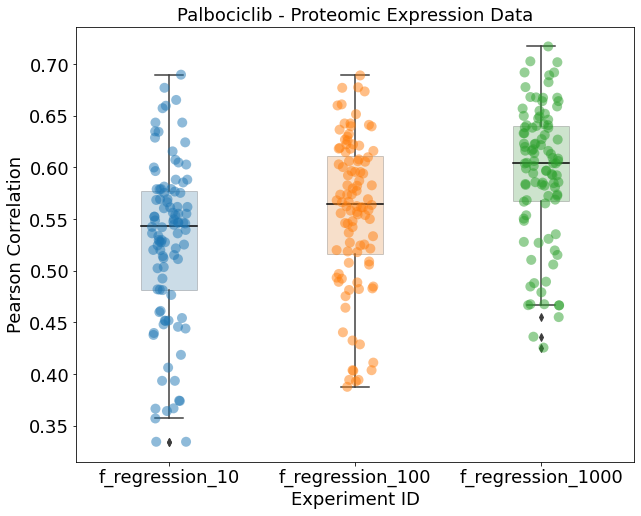

In [26]:
# plot collection df as a boxplot

import seaborn as sns
import matplotlib.pyplot as plt

import Visualisation as vis

fig, ax = plt.subplots(figsize=(10,8))
    
vis.plot_box_plot(collection_df_freg_proteome, 'exp_id', 'pearson_corr', 'Palbociclib - Proteomic Expression Data',
                'Experiment ID', 'Pearson Correlation', ax=ax)

# show the plot
plt.show()


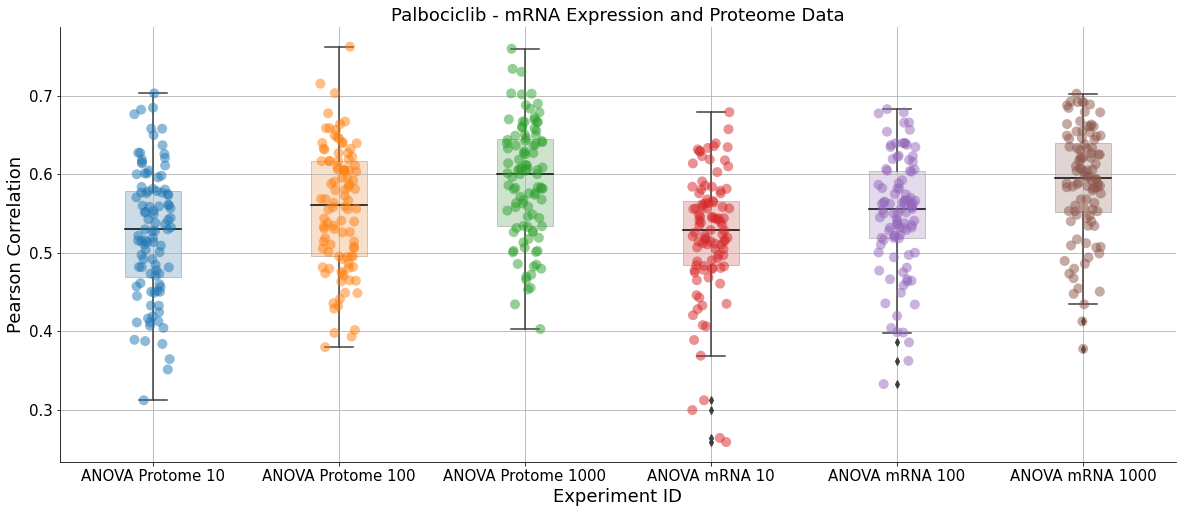

In [39]:
# combine the results from the two datasets

collection_df_freg_all = pd.concat([collection_df_freg_proteome, collection_df_freg], ignore_index=True)

# plot collection df as a boxplot

fig, ax = plt.subplots(figsize=(20,8))

vis.plot_box_plot(collection_df_freg_all, 'exp_id', 'pearson_corr', 'Palbociclib - mRNA Expression and Proteome Data',
                'Experiment ID', 'Pearson Correlation', ax=ax, tick_fontsize=15)          

sns.despine()
plt.grid()
# show the plot
plt.show()

### Selection using STRING

In [46]:
# using STRING database to select the 1st,2nd and 3rd degree neighbours of the drug target

import pandas as pd

drug_targets = ['CDK4', 'CDK6']
first_degree_neighbours = []
second_degree_neighbours = []
third_degree_neighbours = []

for drug_target in drug_targets:
    string_id = utils.get_protein_id_by_name(drug_target, string_df_info, string_df_alias)
    if string_id is not None:
        first_interactors_string_id = utils.get_protein_interactors(string_id, string_df, score_threshold=900)
        for ii in first_interactors_string_id:
            interactor_name = utils.get_protein_name_by_id(ii, goncalve_to_string_id_df, 
                                                           field_name='goncalve_protein_id',
                                                           check_field_name='string_protein_id')
            if interactor_name is not None:
                first_degree_neighbours.append(interactor_name)

print(f'first degree neighbours size: {len(first_degree_neighbours)}')
print(f'first degree neighbours: {first_degree_neighbours}')

first degree neighbours size: 66
first degree neighbours: ['P07900;HS90A_HUMAN', 'Q14186;TFDP1_HUMAN', 'O95067;CCNB2_HUMAN', 'P20248;CCNA2_HUMAN', 'Q00535;CDK5_HUMAN', 'P84022;SMAD3_HUMAN', 'Q16543;CDC37_HUMAN', 'O75832;PSD10_HUMAN', 'P04637;P53_HUMAN', 'O60563;CCNT1_HUMAN', 'P51946;CCNH_HUMAN', 'P00519;ABL1_HUMAN', 'O43502;RA51C_HUMAN', 'P31947;1433S_HUMAN', 'P15090;FABP4_HUMAN', 'Q13547;HDAC1_HUMAN', 'P50750;CDK9_HUMAN', 'P12004;PCNA_HUMAN', 'P07948;LYN_HUMAN', 'P50613;CDK7_HUMAN', 'P24385;CCND1_HUMAN', 'P08238;HS90B_HUMAN', 'Q13951;PEBB_HUMAN', 'P49715;CEBPA_HUMAN', 'P51948;MAT1_HUMAN', 'P49918;CDN1C_HUMAN', 'Q13309;SKP2_HUMAN', 'Q00534;CDK6_HUMAN', 'Q13485;SMAD4_HUMAN', 'Q9P287;BCCIP_HUMAN', 'P14635;CCNB1_HUMAN', 'P24941;CDK2_HUMAN', 'P42771;CDN2A_HUMAN', 'P49841;GSK3B_HUMAN', 'P42773;CDN2C_HUMAN', 'Q9P2W1;HOP2_HUMAN', 'P16989;YBOX3_HUMAN', 'P06493;CDK1_HUMAN', 'Q9BWT6;MND1_HUMAN', 'P12931;SRC_HUMAN', 'P06400;RB_HUMAN', 'P49918;CDN1C_HUMAN', 'P51948;MAT1_HUMAN', 'P14635;CCNB1_HUMAN

In [50]:
# get the second degree neighbours using first_interactors_string_id

for ii in first_interactors_string_id:
    second_interactors_string_id = utils.get_protein_interactors(ii, string_df, score_threshold=900)
    for sec_ii in second_interactors_string_id:
        interactor_name = utils.get_protein_name_by_id(sec_ii, goncalve_to_string_id_df, 
                                                       field_name='goncalve_protein_id',
                                                       check_field_name='string_protein_id')
        if interactor_name is not None:
            second_degree_neighbours.append(interactor_name)

second_degree_neighbours = list(set(second_degree_neighbours + first_degree_neighbours))
print(f'second degree neighbours size: {len(second_degree_neighbours)}')
print(f'second degree neighbours: {second_degree_neighbours}')



second degree neighbours size: 967
second degree neighbours: ['Q9H9B1;EHMT1_HUMAN', 'P29083;T2EA_HUMAN', 'Q8N3R9;PALS1_HUMAN', 'P17302;CXA1_HUMAN', 'Q92621;NU205_HUMAN', 'Q96KQ7;EHMT2_HUMAN', 'Q9UQB8;BAIP2_HUMAN', 'Q9UJX3;APC7_HUMAN', 'Q13952;NFYC_HUMAN', 'Q9Y6W5;WASF2_HUMAN', 'Q2NKX8;ERC6L_HUMAN', 'P16401;H15_HUMAN', 'Q13191;CBLB_HUMAN', 'P07996;TSP1_HUMAN', 'Q9UJX2;CDC23_HUMAN', 'P18754;RCC1_HUMAN', 'Q96F07;CYFP2_HUMAN', 'P42229;STA5A_HUMAN', 'P36954;RPB9_HUMAN', 'P61244;MAX_HUMAN', 'Q12959;DLG1_HUMAN', 'Q12834;CDC20_HUMAN', 'P62826;RAN_HUMAN', 'Q00653;NFKB2_HUMAN', 'P57740;NU107_HUMAN', 'Q13287;NMI_HUMAN', 'Q9NYZ3;GTSE1_HUMAN', 'Q96EY1;DNJA3_HUMAN', 'P09619;PGFRB_HUMAN', 'Q9UBI6;GBG12_HUMAN', 'P00374;DYR_HUMAN', 'Q9UJQ4;SALL4_HUMAN', 'P50148;GNAQ_HUMAN', 'P06493;CDK1_HUMAN', 'Q7Z3B4;NUP54_HUMAN', 'P16144;ITB4_HUMAN', 'P05121;PAI1_HUMAN', 'P18084;ITB5_HUMAN', 'P63208;SKP1_HUMAN', 'P46109;CRKL_HUMAN', 'O75116;ROCK2_HUMAN', 'O15264;MK13_HUMAN', 'Q16537;2A5E_HUMAN', 'Q6WCQ1;MPRIP_HUMAN'

In [51]:
# get the third degree neighbours using second_interactors_string_id

for ii in second_interactors_string_id:
    third_interactors_string_id = utils.get_protein_interactors(ii, string_df, score_threshold=900)
    for third_ii in third_interactors_string_id:
        interactor_name = utils.get_protein_name_by_id(third_ii, goncalve_to_string_id_df, 
                                                       field_name='goncalve_protein_id',
                                                       check_field_name='string_protein_id')
        if interactor_name is not None:
            third_degree_neighbours.append(interactor_name)

third_degree_neighbours = list(set(third_degree_neighbours + second_degree_neighbours))
print(f'third degree neighbours size: {len(third_degree_neighbours)}')
print(f'third degree neighbours: {third_degree_neighbours}')

third degree neighbours size: 993
third degree neighbours: ['Q9H9B1;EHMT1_HUMAN', 'P29083;T2EA_HUMAN', 'Q8N3R9;PALS1_HUMAN', 'P17302;CXA1_HUMAN', 'Q92621;NU205_HUMAN', 'Q96KQ7;EHMT2_HUMAN', 'Q9UQB8;BAIP2_HUMAN', 'Q9UJX3;APC7_HUMAN', 'Q13952;NFYC_HUMAN', 'Q13191;CBLB_HUMAN', 'P16401;H15_HUMAN', 'Q2NKX8;ERC6L_HUMAN', 'Q9Y6W5;WASF2_HUMAN', 'P07996;TSP1_HUMAN', 'Q9UJX2;CDC23_HUMAN', 'P18754;RCC1_HUMAN', 'Q96F07;CYFP2_HUMAN', 'P42229;STA5A_HUMAN', 'P36954;RPB9_HUMAN', 'P61244;MAX_HUMAN', 'Q12959;DLG1_HUMAN', 'Q12834;CDC20_HUMAN', 'P62826;RAN_HUMAN', 'Q00653;NFKB2_HUMAN', 'P57740;NU107_HUMAN', 'Q13287;NMI_HUMAN', 'Q9NYZ3;GTSE1_HUMAN', 'Q96EY1;DNJA3_HUMAN', 'P09619;PGFRB_HUMAN', 'Q9UBI6;GBG12_HUMAN', 'P00374;DYR_HUMAN', 'Q9UJQ4;SALL4_HUMAN', 'P50148;GNAQ_HUMAN', 'P06493;CDK1_HUMAN', 'Q7Z3B4;NUP54_HUMAN', 'P16144;ITB4_HUMAN', 'P05121;PAI1_HUMAN', 'P18084;ITB5_HUMAN', 'P63208;SKP1_HUMAN', 'P46109;CRKL_HUMAN', 'O75116;ROCK2_HUMAN', 'O15264;MK13_HUMAN', 'Q16537;2A5E_HUMAN', 'Q6WCQ1;MPRIP_HUMAN', 

In [52]:
# select features from the first degree neighbours

feature_data_first_degree = feature_data[first_degree_neighbours]

feature_data_first_degree.head()

,P07900;HS90A_HUMAN,Q14186;TFDP1_HUMAN,O95067;CCNB2_HUMAN,P20248;CCNA2_HUMAN,Q00535;CDK5_HUMAN,P84022;SMAD3_HUMAN,Q16543;CDC37_HUMAN,O75832;PSD10_HUMAN,P04637;P53_HUMAN,O60563;CCNT1_HUMAN,...,Q14186;TFDP1_HUMAN,P20248;CCNA2_HUMAN,P00519;ABL1_HUMAN,P51946;CCNH_HUMAN,P07948;LYN_HUMAN,P12004;PCNA_HUMAN,P50613;CDK7_HUMAN,Q13547;HDAC1_HUMAN,P31947;1433S_HUMAN,P24385;CCND1_HUMAN
SIDM00042,5.77254,0.0,0.0,0.00000,0.00000,0.0,3.46590,0.00000,0.00000,0.0,...,0.0,0.00000,0.0,0.0,0.00000,5.02710,0.0,0.00000,7.33660,0.0
SIDM00044,9.78612,0.0,0.0,0.00000,2.70255,0.0,6.71636,2.76831,0.00000,0.0,...,0.0,0.00000,0.0,0.0,3.14498,7.77206,0.0,4.41623,9.81594,0.0
SIDM00045,9.73268,0.0,0.0,2.67813,2.04839,0.0,6.03778,2.57275,3.68677,0.0,...,0.0,2.67813,0.0,0.0,2.52465,8.05159,0.0,2.89522,9.62882,0.0
SIDM00047,8.56821,0.0,0.0,0.00000,2.27327,0.0,5.87896,0.00000,0.00000,0.0,...,0.0,0.00000,0.0,0.0,3.50726,7.31040,0.0,3.01497,9.74553,0.0
SIDM00049,9.63436,0.0,0.0,0.00000,2.72025,0.0,6.21928,0.00000,1.85910,0.0,...,0.0,0.00000,0.0,0.0,3.05039,8.30676,0.0,1.82792,10.61189,0.0


score using selected features: 2.5404


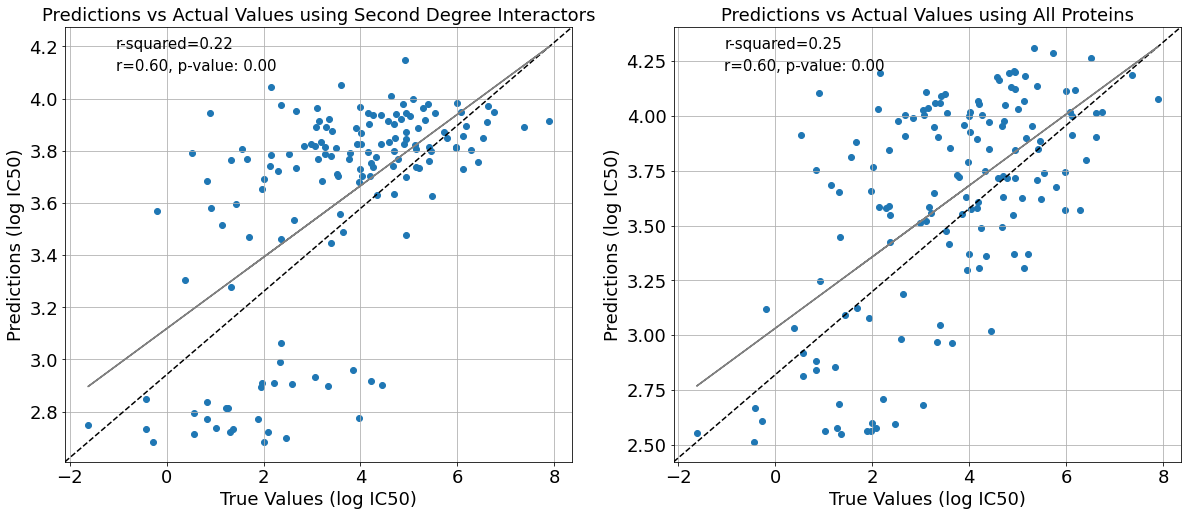

In [55]:
# split the data into train and test set

from sklearn.model_selection import train_test_split

# import lasso regression model

from sklearn.linear_model import Lasso

import numpy as np

X_train, X_test, y_train, y_test = train_test_split(feature_data, label_data, test_size=0.2,
                                                    random_state=np.random.randint(1000))

# train the model 

# perform feature selection on the training set, using n degree interactors

n_degree_neighbours = second_degree_neighbours 

X_train_first_degree = X_train[n_degree_neighbours]

# train the model on the selected features

lasso = Lasso()
lasso.fit(X_train_first_degree, y_train)

lasso_all_features = Lasso()
lasso_all_features.fit(X_train, y_train)



# get the predictions

y_pred = lasso.predict(X_test[n_degree_neighbours])
predictions_all_features = lasso_all_features.predict(X_test)

# get the score

from sklearn.metrics import mean_squared_error

score = mean_squared_error(y_test, y_pred)

print(f'score using selected features: {score:.4f}')

# plot the predictions vs the actual values

import matplotlib.pyplot as plt
import Visualisation as vis

# make a 1x2 subplots
fig, ax = plt.subplots(1, 2, figsize=(20,8))

# for each axis, plot the predictions vs the actual values
vis.plot_predictions_vs_actual_values(y_test, y_pred, ax=ax[0],
                                        title='Predictions vs Actual Values using Second Degree Interactors',
                                        x_label='True Values (log IC50)', y_label='Predictions (log IC50)',
                                        minitext_size=15)
vis.plot_predictions_vs_actual_values(y_test, predictions_all_features, ax=ax[1],
                                        title='Predictions vs Actual Values using All Proteins',            
                                        x_label='True Values (log IC50)', y_label='Predictions (log IC50)',
                                        minitext_size=15)

# show the plot
plt.show()